In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [23]:
model_name = "EfficientNetB0"

DATA_DIR = "data"
TRAIN_DIR = os.path.join("..", DATA_DIR, "train")
VAL_DIR   = os.path.join("..", DATA_DIR, "valid")
TEST_DIR  = os.path.join("..", DATA_DIR, "test")

checkpoints_dir = Path(os.getcwd()).parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

CHECKPOINT_PATH_FE = checkpoints_dir / "best_effnet_b0_feature_extraction-only-fe.weights.h5"
FINAL_MODEL_PATH = checkpoints_dir / "effnet_b0_transfer_final-only-fe.keras"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_EPOCHS = 50 # Increased since we're only doing feature extraction

In [24]:
preproc = tf.keras.applications.efficientnet.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preproc,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preproc
)

train_gen = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    str(VAL_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print(f"Number of classes: {NUM_CLASSES}")

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.
Classes: ['1', '10', '10 (new)', '100', '20', '20 (new)', '200', '5', '50']
Number of classes: 9


In [25]:
y_train = train_gen.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight)

Class weights: {0: np.float64(4.883333333333334), 1: np.float64(0.9301587301587302), 2: np.float64(0.9242902208201893), 3: np.float64(0.9301587301587302), 4: np.float64(0.9099378881987578), 5: np.float64(0.846820809248555), 6: np.float64(0.9361022364217252), 7: np.float64(0.8772455089820359), 8: np.float64(0.9301587301587302)}


In [26]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze base for feature extraction

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)  # Added batch norm
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu")(x)  # Increased capacity
x = layers.BatchNormalization()(x)  # Added batch norm
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,846,252 (18.49 MB)

 Trainable params: 793,097 (3.03 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [27]:
callbacks = [
    ModelCheckpoint(
        str(CHECKPOINT_PATH_FE), 
        monitor="val_accuracy", 
        mode='max', 
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy", 
        mode='max', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy", 
        mode='max', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6, 
        verbose=1
    )
]

In [28]:
# ========================
# Phase 1: Feature Extraction
# ========================
print("\n" + "="*50)
print("PHASE 1: Feature Extraction (Base Model Frozen)")
print("="*50)


history = model.fit(
    train_gen,
    epochs=NUM_EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight
)


PHASE 1: Feature Extraction (Base Model Frozen)
Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3821 - loss: 1.9759
Epoch 1: val_accuracy improved from None to 0.74474, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction-only-fe.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.4983 - loss: 1.6743 - val_accuracy: 0.7447 - val_loss: 1.2552 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6893 - loss: 1.1827
Epoch 2: val_accuracy improved from 0.74474 to 0.80132, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction-only-fe.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.6936 - loss: 1.1873 - val_accuracy: 0.8013 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7437 - loss


FINAL EVALUATION ON TEST SET
Loaded best weights from c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction-only-fe.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9793 - loss: 0.6176

Test Accuracy: 0.9793 | Test Loss: 0.6176
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step


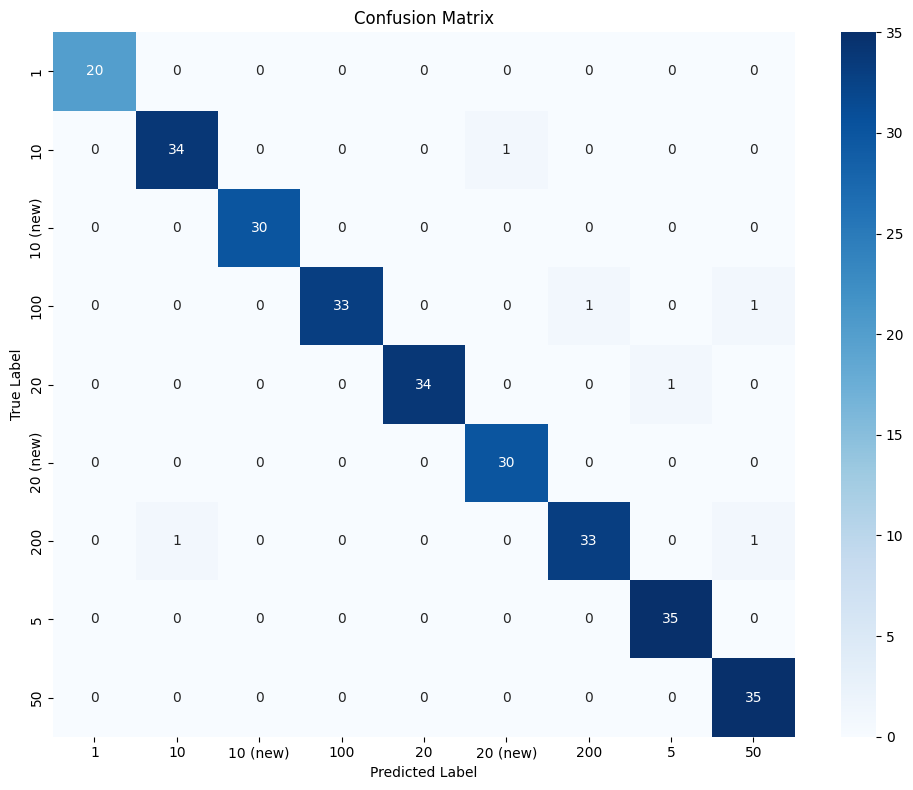


Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        20
          10     0.9714    0.9714    0.9714        35
    10 (new)     1.0000    1.0000    1.0000        30
         100     1.0000    0.9429    0.9706        35
          20     1.0000    0.9714    0.9855        35
    20 (new)     0.9677    1.0000    0.9836        30
         200     0.9706    0.9429    0.9565        35
           5     0.9722    1.0000    0.9859        35
          50     0.9459    1.0000    0.9722        35

    accuracy                         0.9793       290
   macro avg     0.9809    0.9810    0.9806       290
weighted avg     0.9798    0.9793    0.9793       290


Saved final model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\effnet_b0_transfer_final-only-fe.keras


In [29]:
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

model.load_weights(str(CHECKPOINT_PATH_FE))
print(f"Loaded best weights from {CHECKPOINT_PATH_FE}")

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Save final model
model.save(str(FINAL_MODEL_PATH))
print(f"\nSaved final model to {FINAL_MODEL_PATH}")

In [30]:
def plot_training_curves(history, test_acc=None, test_loss=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)
    
    axes[0].plot(epochs_range, acc, 'b-', label='Train Acc', linewidth=2)
    axes[0].plot(epochs_range, val_acc, 'r-', label='Val Acc', linewidth=2)
    if test_acc is not None:
        axes[0].axhline(y=test_acc, linestyle='--', color='green', 
                       label=f'Test Acc: {test_acc:.4f}', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    axes[1].plot(epochs_range, loss, 'b-', label='Train Loss', linewidth=2)
    axes[1].plot(epochs_range, val_loss, 'r-', label='Val Loss', linewidth=2)
    if test_loss is not None:
        axes[1].axhline(y=test_loss, linestyle='--', color='green', 
                       label=f'Test Loss: {test_loss:.4f}', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

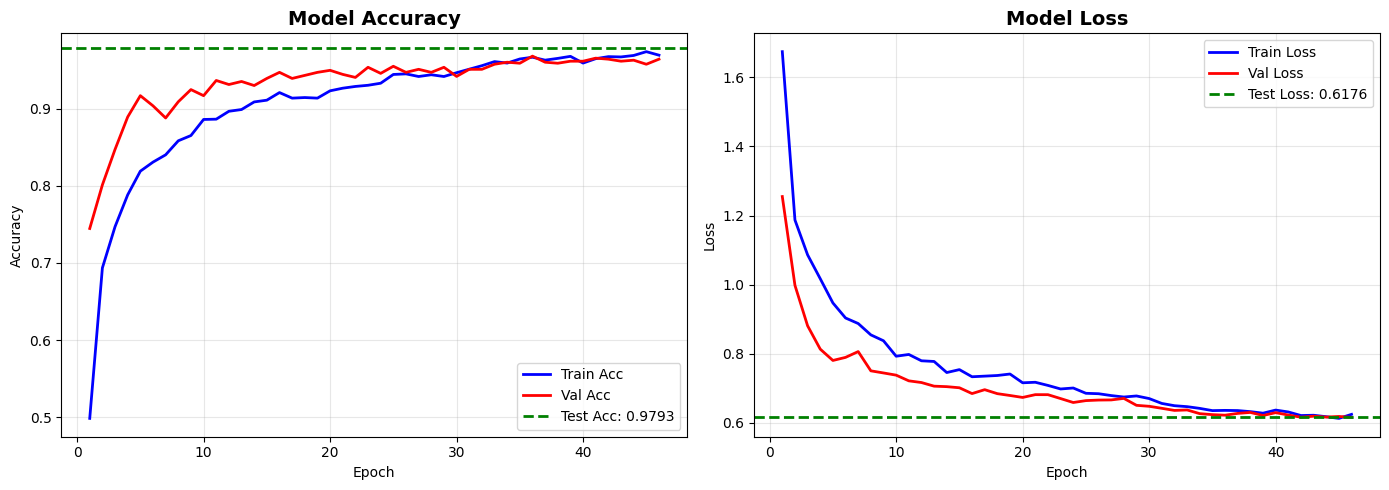


TRAINING COMPLETE


In [31]:
plot_training_curves(history, test_acc=test_acc, test_loss=test_loss)

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)